In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import nltk
import pickle
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from lxml import html
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\vinay\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [12]:
flipkarts = []

def get_soup(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

def get_reviews(soup):
    flipkarts_a = []
    containers = soup.findAll("div", {'class': '_2wrUUKlw _3hFEdNs8'})
    for i in containers:
        ratings = i.select_one('span.ui_bubble_rating')['class']
        ratings = ratings[1].split('_')[-1]
        #print(ratings)
        re = {
        'rating' : ratings,
        'review' : i.find("q", {"class": "IRsGHoPm"}).text,
        }
        flipkarts_a.append(re)
    return flipkarts_a

for x in range(1,660,5):
    url = 'https://www.tripadvisor.in/Hotel_Review-g297628-d307038-Reviews-or'+str(x)+'-Golden_Palms_Hotel_Spa-Bengaluru_Bangalore_District_Karnataka.html#REVIEWS'
    soup = get_soup(url)
    #print(f'Getting page: {x}')
    
    flipkarts = flipkarts + get_reviews(soup)
   # print(len(flipkarts))
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break
df = pd.DataFrame(flipkarts)
print(df.shape)
df.head()

(660, 2)


,rating,review
0,30,The property is very good no doubt but the foo...
1,40,Love everything especially the pool. Must visi...
2,50,Nice place to visit for a family dining. Staff...
3,50,As an event manager its a nice place to organi...
4,50,We had an amazing weekend stay experience with...


In [13]:
df.groupby('rating').count()

,review
rating,
10,70
20,55
30,119
40,240
50,176


In [14]:
df.to_csv('Golden_palms.csv')

In [15]:
with open('Golden_palms.csv',encoding='utf-8') as f:
    bb_df = pd.read_csv(f)
f.close()
bb_df.drop('Unnamed: 0', axis=1, inplace=True)
bb_df

,rating,review
0,30,The property is very good no doubt but the foo...
1,40,Love everything especially the pool. Must visi...
2,50,Nice place to visit for a family dining. Staff...
3,50,As an event manager its a nice place to organi...
4,50,We had an amazing weekend stay experience with...
...,...,...
655,30,"We checked in here for 3 days, whilst exhibiti..."
656,50,We visited Bangalore for the third time and th...
657,30,"The hotel is not a 5 star, but is far better t..."
658,10,"Hello I am farook, one of my favou..."


In [146]:
#bb_df['review'] = bb_df['review'].str.replace('READ MORE', '')
#bb_df['review'] = bb_df['review'].str.replace('phone', '')
#bb_df['review'] = bb_df['review'].str.replace('good', '')
#bb_df['review'] = bb_df['review'].str.replace('...', '')

#bb_df

,rating,review
0,1,The network is not doing a job. Where other s...
1,1,The body is very delicate.. it got scratches a...
2,1,WASTE OF MONEY. 1st thing is the charge. it ha...
3,1,After use more then 6 days i write this review...
4,1,If you are camera lover the don't wst your mo...
...,...,...
4923,4,Ok camera is not expected quality overall
4924,4,It is very and its worth buying
4925,4,"dude.....video doesn't support 1080 at 60fps,j..."
4926,4,Good .. slightly higher price


In [16]:
#tokenizing the reviews
bb_df['tokenized'] = bb_df['review'].apply(word_tokenize)
#converting all to lowercase
bb_df['lower'] = bb_df['tokenized'].apply(lambda x: [word.lower() for word in x])
#removing punctuations
punc = string.punctuation
bb_df['no_punc'] = bb_df['lower'].apply(lambda x: [word for word in x if word not in punc])
#removing stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['.',';'])
bb_df['stopwords_removed'] = bb_df['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
bb_df.head()

,rating,review,tokenized,lower,no_punc,stopwords_removed
0,30,The property is very good no doubt but the foo...,"[The, property, is, very, good, no, doubt, but...","[the, property, is, very, good, no, doubt, but...","[the, property, is, very, good, no, doubt, but...","[property, good, doubt, food, upto, mark, hous..."
1,40,Love everything especially the pool. Must visi...,"[Love, everything, especially, the, pool, ., M...","[love, everything, especially, the, pool, ., m...","[love, everything, especially, the, pool, must...","[love, everything, especially, pool, must, vis..."
2,50,Nice place to visit for a family dining. Staff...,"[Nice, place, to, visit, for, a, family, dinin...","[nice, place, to, visit, for, a, family, dinin...","[nice, place, to, visit, for, a, family, dinin...","[nice, place, visit, family, dining, staff, pl..."
3,50,As an event manager its a nice place to organi...,"[As, an, event, manager, its, a, nice, place, ...","[as, an, event, manager, its, a, nice, place, ...","[as, an, event, manager, its, a, nice, place, ...","[event, manager, nice, place, organize, corpor..."
4,50,We had an amazing weekend stay experience with...,"[We, had, an, amazing, weekend, stay, experien...","[we, had, an, amazing, weekend, stay, experien...","[we, had, an, amazing, weekend, stay, experien...","[amazing, weekend, stay, experience, exception..."


In [17]:
#lemmitization
#first apply parts of speech tags
bb_df['pos_tags'] = bb_df['stopwords_removed'].apply(nltk.tag.pos_tag)
bb_df.head()

,rating,review,tokenized,lower,no_punc,stopwords_removed,pos_tags
0,30,The property is very good no doubt but the foo...,"[The, property, is, very, good, no, doubt, but...","[the, property, is, very, good, no, doubt, but...","[the, property, is, very, good, no, doubt, but...","[property, good, doubt, food, upto, mark, hous...","[(property, NN), (good, JJ), (doubt, NN), (foo..."
1,40,Love everything especially the pool. Must visi...,"[Love, everything, especially, the, pool, ., M...","[love, everything, especially, the, pool, ., m...","[love, everything, especially, the, pool, must...","[love, everything, especially, pool, must, vis...","[(love, VB), (everything, NN), (especially, RB..."
2,50,Nice place to visit for a family dining. Staff...,"[Nice, place, to, visit, for, a, family, dinin...","[nice, place, to, visit, for, a, family, dinin...","[nice, place, to, visit, for, a, family, dinin...","[nice, place, visit, family, dining, staff, pl...","[(nice, JJ), (place, NN), (visit, NN), (family..."
3,50,As an event manager its a nice place to organi...,"[As, an, event, manager, its, a, nice, place, ...","[as, an, event, manager, its, a, nice, place, ...","[as, an, event, manager, its, a, nice, place, ...","[event, manager, nice, place, organize, corpor...","[(event, NN), (manager, NN), (nice, JJ), (plac..."
4,50,We had an amazing weekend stay experience with...,"[We, had, an, amazing, weekend, stay, experien...","[we, had, an, amazing, weekend, stay, experien...","[we, had, an, amazing, weekend, stay, experien...","[amazing, weekend, stay, experience, exception...","[(amazing, VBG), (weekend, NN), (stay, NN), (e..."


In [18]:
#lemmitizing only certain parts of speech using the custom function
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
bb_df['wordnet_pos'] = bb_df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
bb_df['lemmatized'] = bb_df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
bb_df.head()

,rating,review,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,30,The property is very good no doubt but the foo...,"[The, property, is, very, good, no, doubt, but...","[the, property, is, very, good, no, doubt, but...","[the, property, is, very, good, no, doubt, but...","[property, good, doubt, food, upto, mark, hous...","[(property, NN), (good, JJ), (doubt, NN), (foo...","[(property, n), (good, a), (doubt, n), (food, ...","[property, good, doubt, food, upto, mark, hous..."
1,40,Love everything especially the pool. Must visi...,"[Love, everything, especially, the, pool, ., M...","[love, everything, especially, the, pool, ., m...","[love, everything, especially, the, pool, must...","[love, everything, especially, pool, must, vis...","[(love, VB), (everything, NN), (especially, RB...","[(love, v), (everything, n), (especially, r), ...","[love, everything, especially, pool, must, vis..."
2,50,Nice place to visit for a family dining. Staff...,"[Nice, place, to, visit, for, a, family, dinin...","[nice, place, to, visit, for, a, family, dinin...","[nice, place, to, visit, for, a, family, dinin...","[nice, place, visit, family, dining, staff, pl...","[(nice, JJ), (place, NN), (visit, NN), (family...","[(nice, a), (place, n), (visit, n), (family, n...","[nice, place, visit, family, din, staff, pleas..."
3,50,As an event manager its a nice place to organi...,"[As, an, event, manager, its, a, nice, place, ...","[as, an, event, manager, its, a, nice, place, ...","[as, an, event, manager, its, a, nice, place, ...","[event, manager, nice, place, organize, corpor...","[(event, NN), (manager, NN), (nice, JJ), (plac...","[(event, n), (manager, n), (nice, a), (place, ...","[event, manager, nice, place, organize, corpor..."
4,50,We had an amazing weekend stay experience with...,"[We, had, an, amazing, weekend, stay, experien...","[we, had, an, amazing, weekend, stay, experien...","[we, had, an, amazing, weekend, stay, experien...","[amazing, weekend, stay, experience, exception...","[(amazing, VBG), (weekend, NN), (stay, NN), (e...","[(amazing, v), (weekend, n), (stay, n), (exper...","[amaze, weekend, stay, experience, exceptional..."


****Sentiment analysis using text blob****

In [19]:
bb_df_new = bb_df[['rating','lemmatized']]
#forming a string in order to determine the sentiment of review using textblob
bb_df_new['lemma_str'] = [' '.join(map(str,l)) for l in bb_df_new['lemmatized']]
bb_df_new

C:\Users\vinay\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,rating,lemmatized,lemma_str
0,30,"[property, good, doubt, food, upto, mark, hous...",property good doubt food upto mark housekeepin...
1,40,"[love, everything, especially, pool, must, vis...",love everything especially pool must visit nic...
2,50,"[nice, place, visit, family, din, staff, pleas...",nice place visit family din staff pleasant foo...
3,50,"[event, manager, nice, place, organize, corpor...",event manager nice place organize corporate ev...
4,50,"[amaze, weekend, stay, experience, exceptional...",amaze weekend stay experience exceptional seem...
...,...,...,...
655,30,"[check, 3, day, whilst, exhibit, nearby, banga...",check 3 day whilst exhibit nearby bangalore ex...
656,50,"[visit, bangalore, third, time, hotel, like, p...",visit bangalore third time hotel like paradise...
657,30,"[hotel, 5, star, far, well, hotel, stay, india...",hotel 5 star far well hotel stay india rate 3-...
658,10,"[hello, farook, one, favourite, hobby, holiday...",hello farook one favourite hobby holiday ever ...


In [20]:
bb_df_new['sentiment'] = bb_df_new['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
bb_df_new.head()

C:\Users\vinay\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,rating,lemmatized,lemma_str,sentiment
0,30,"[property, good, doubt, food, upto, mark, hous...",property good doubt food upto mark housekeepin...,0.528333
1,40,"[love, everything, especially, pool, must, vis...",love everything especially pool must visit nic...,0.380000
2,50,"[nice, place, visit, family, din, staff, pleas...",nice place visit family din staff pleasant foo...,0.746667
3,50,"[event, manager, nice, place, organize, corpor...",event manager nice place organize corporate ev...,0.466667
4,50,"[amaze, weekend, stay, experience, exceptional...",amaze weekend stay experience exceptional seem...,0.411111


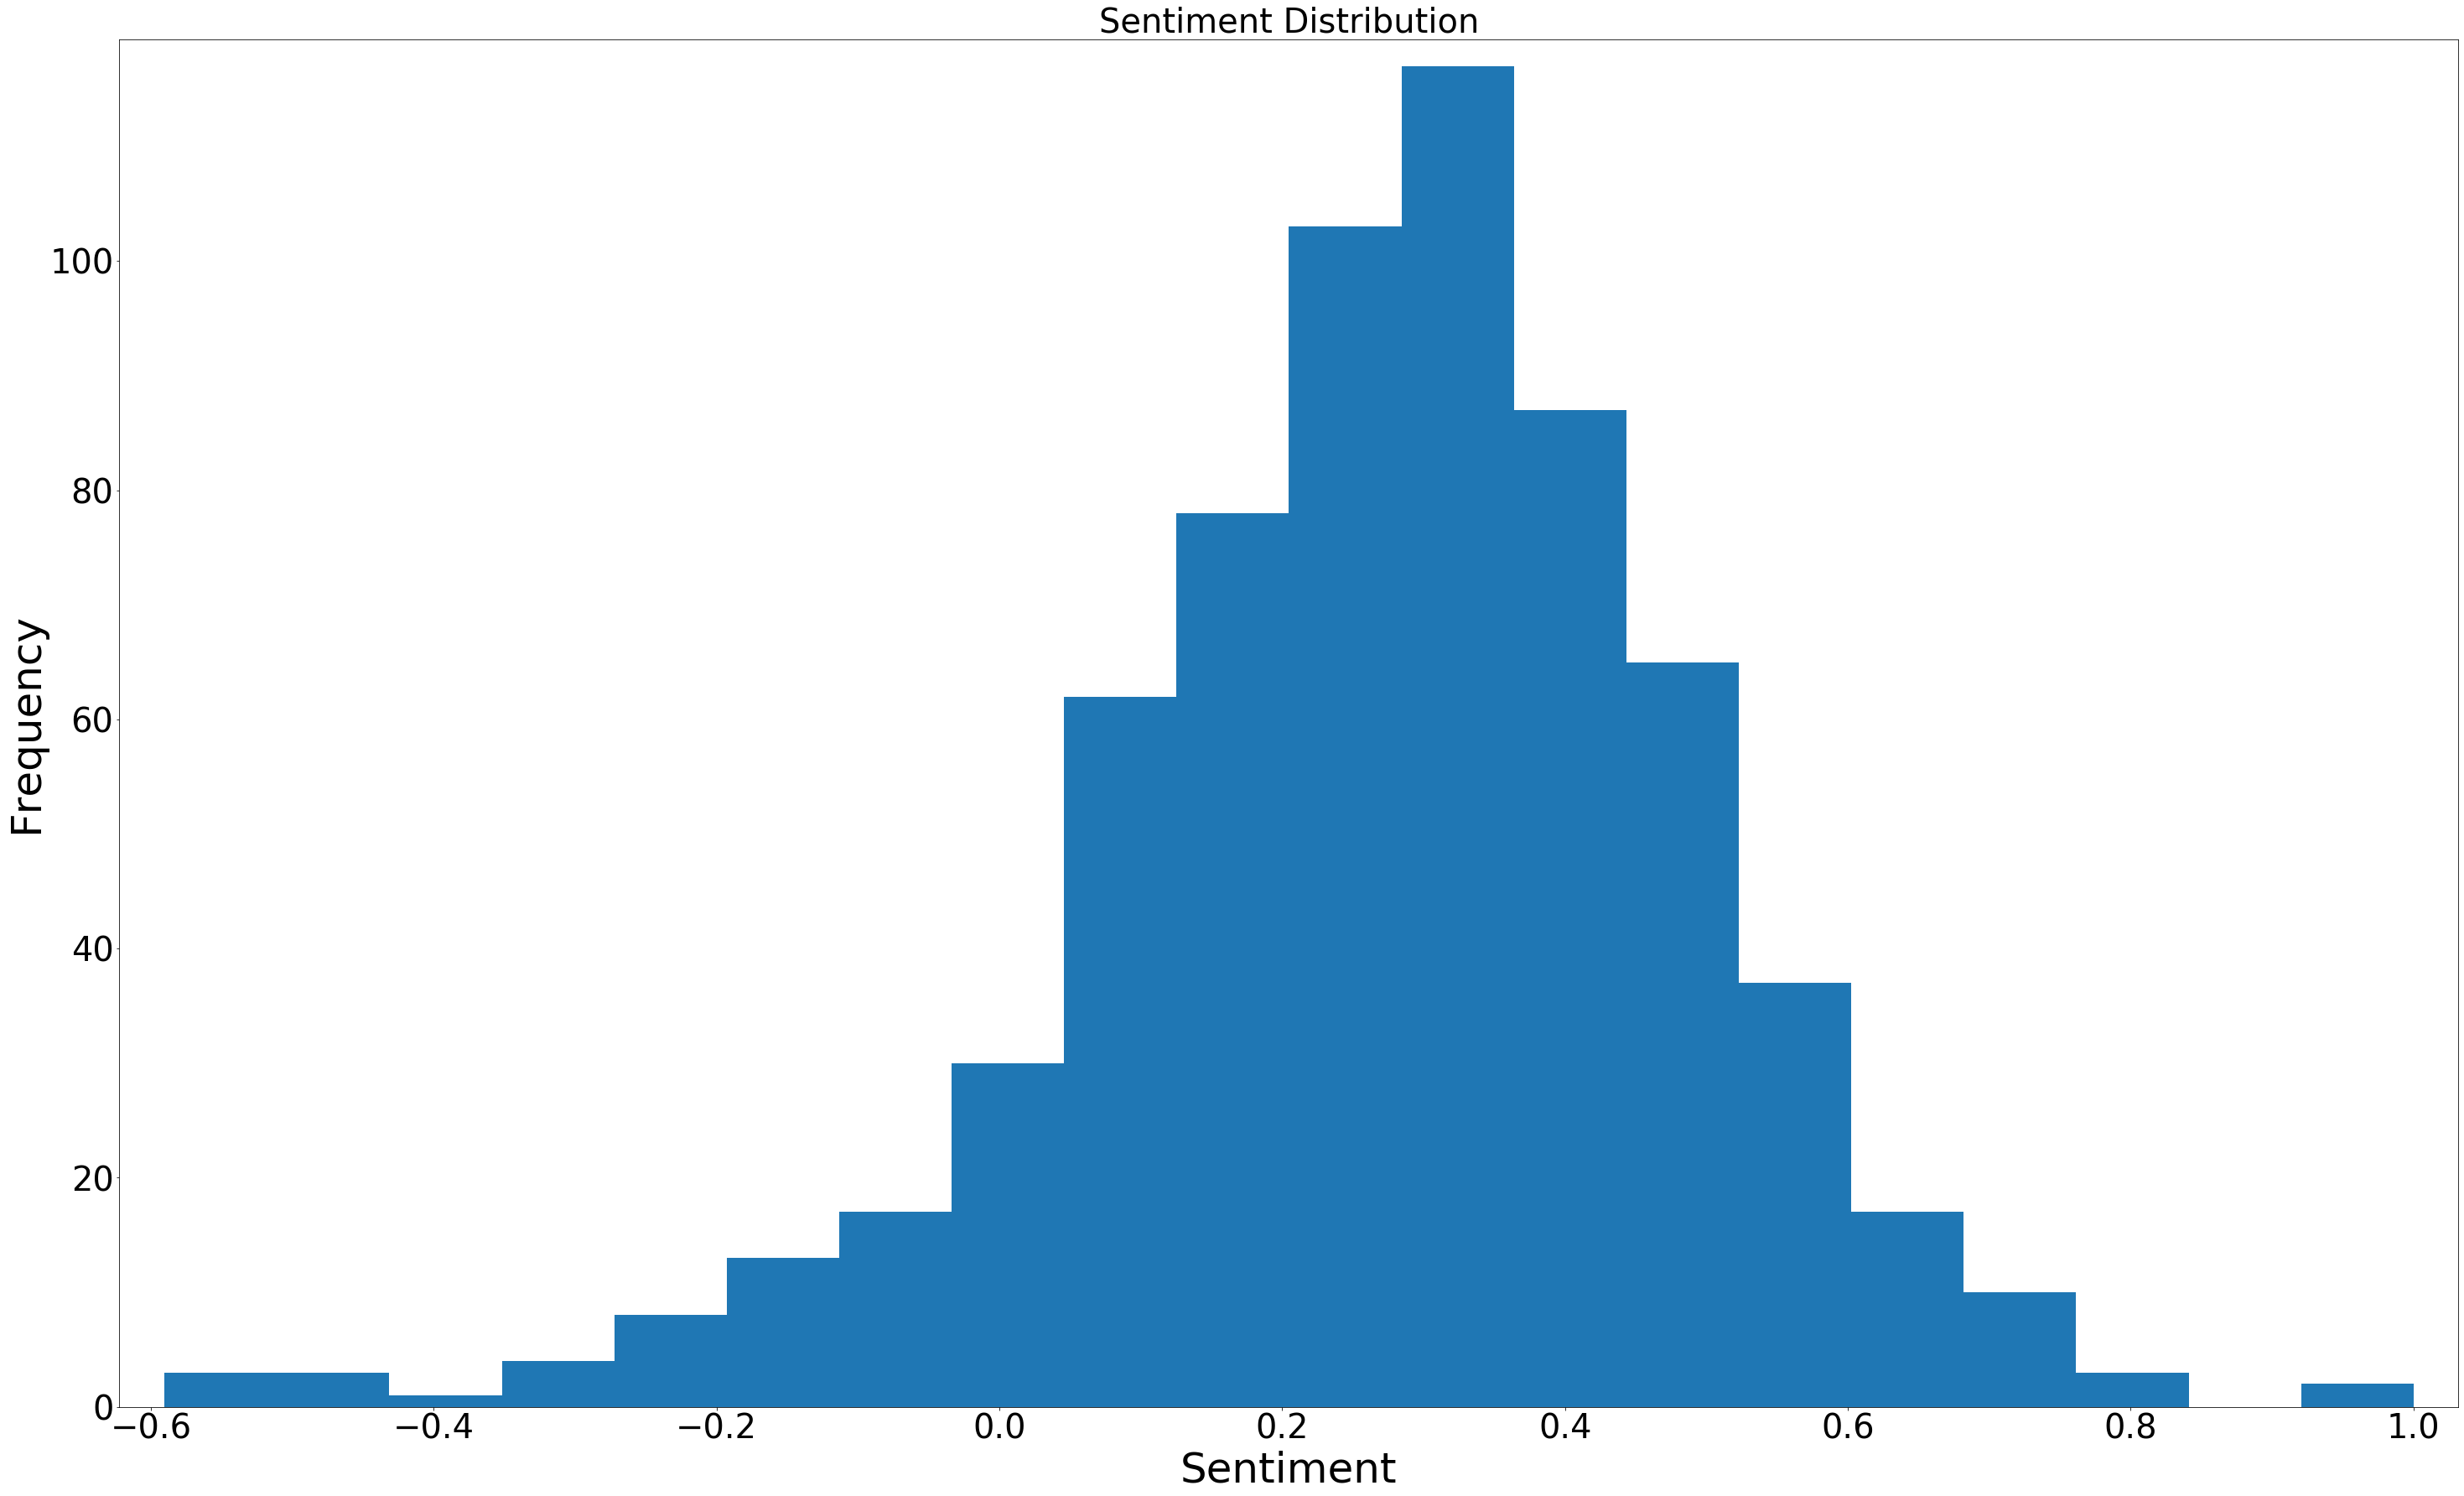

In [21]:
#sentiment distribution
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(bb_df_new['sentiment'], bins=20)
plt.title('Sentiment Distribution', fontsize=40)
plt.show()

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

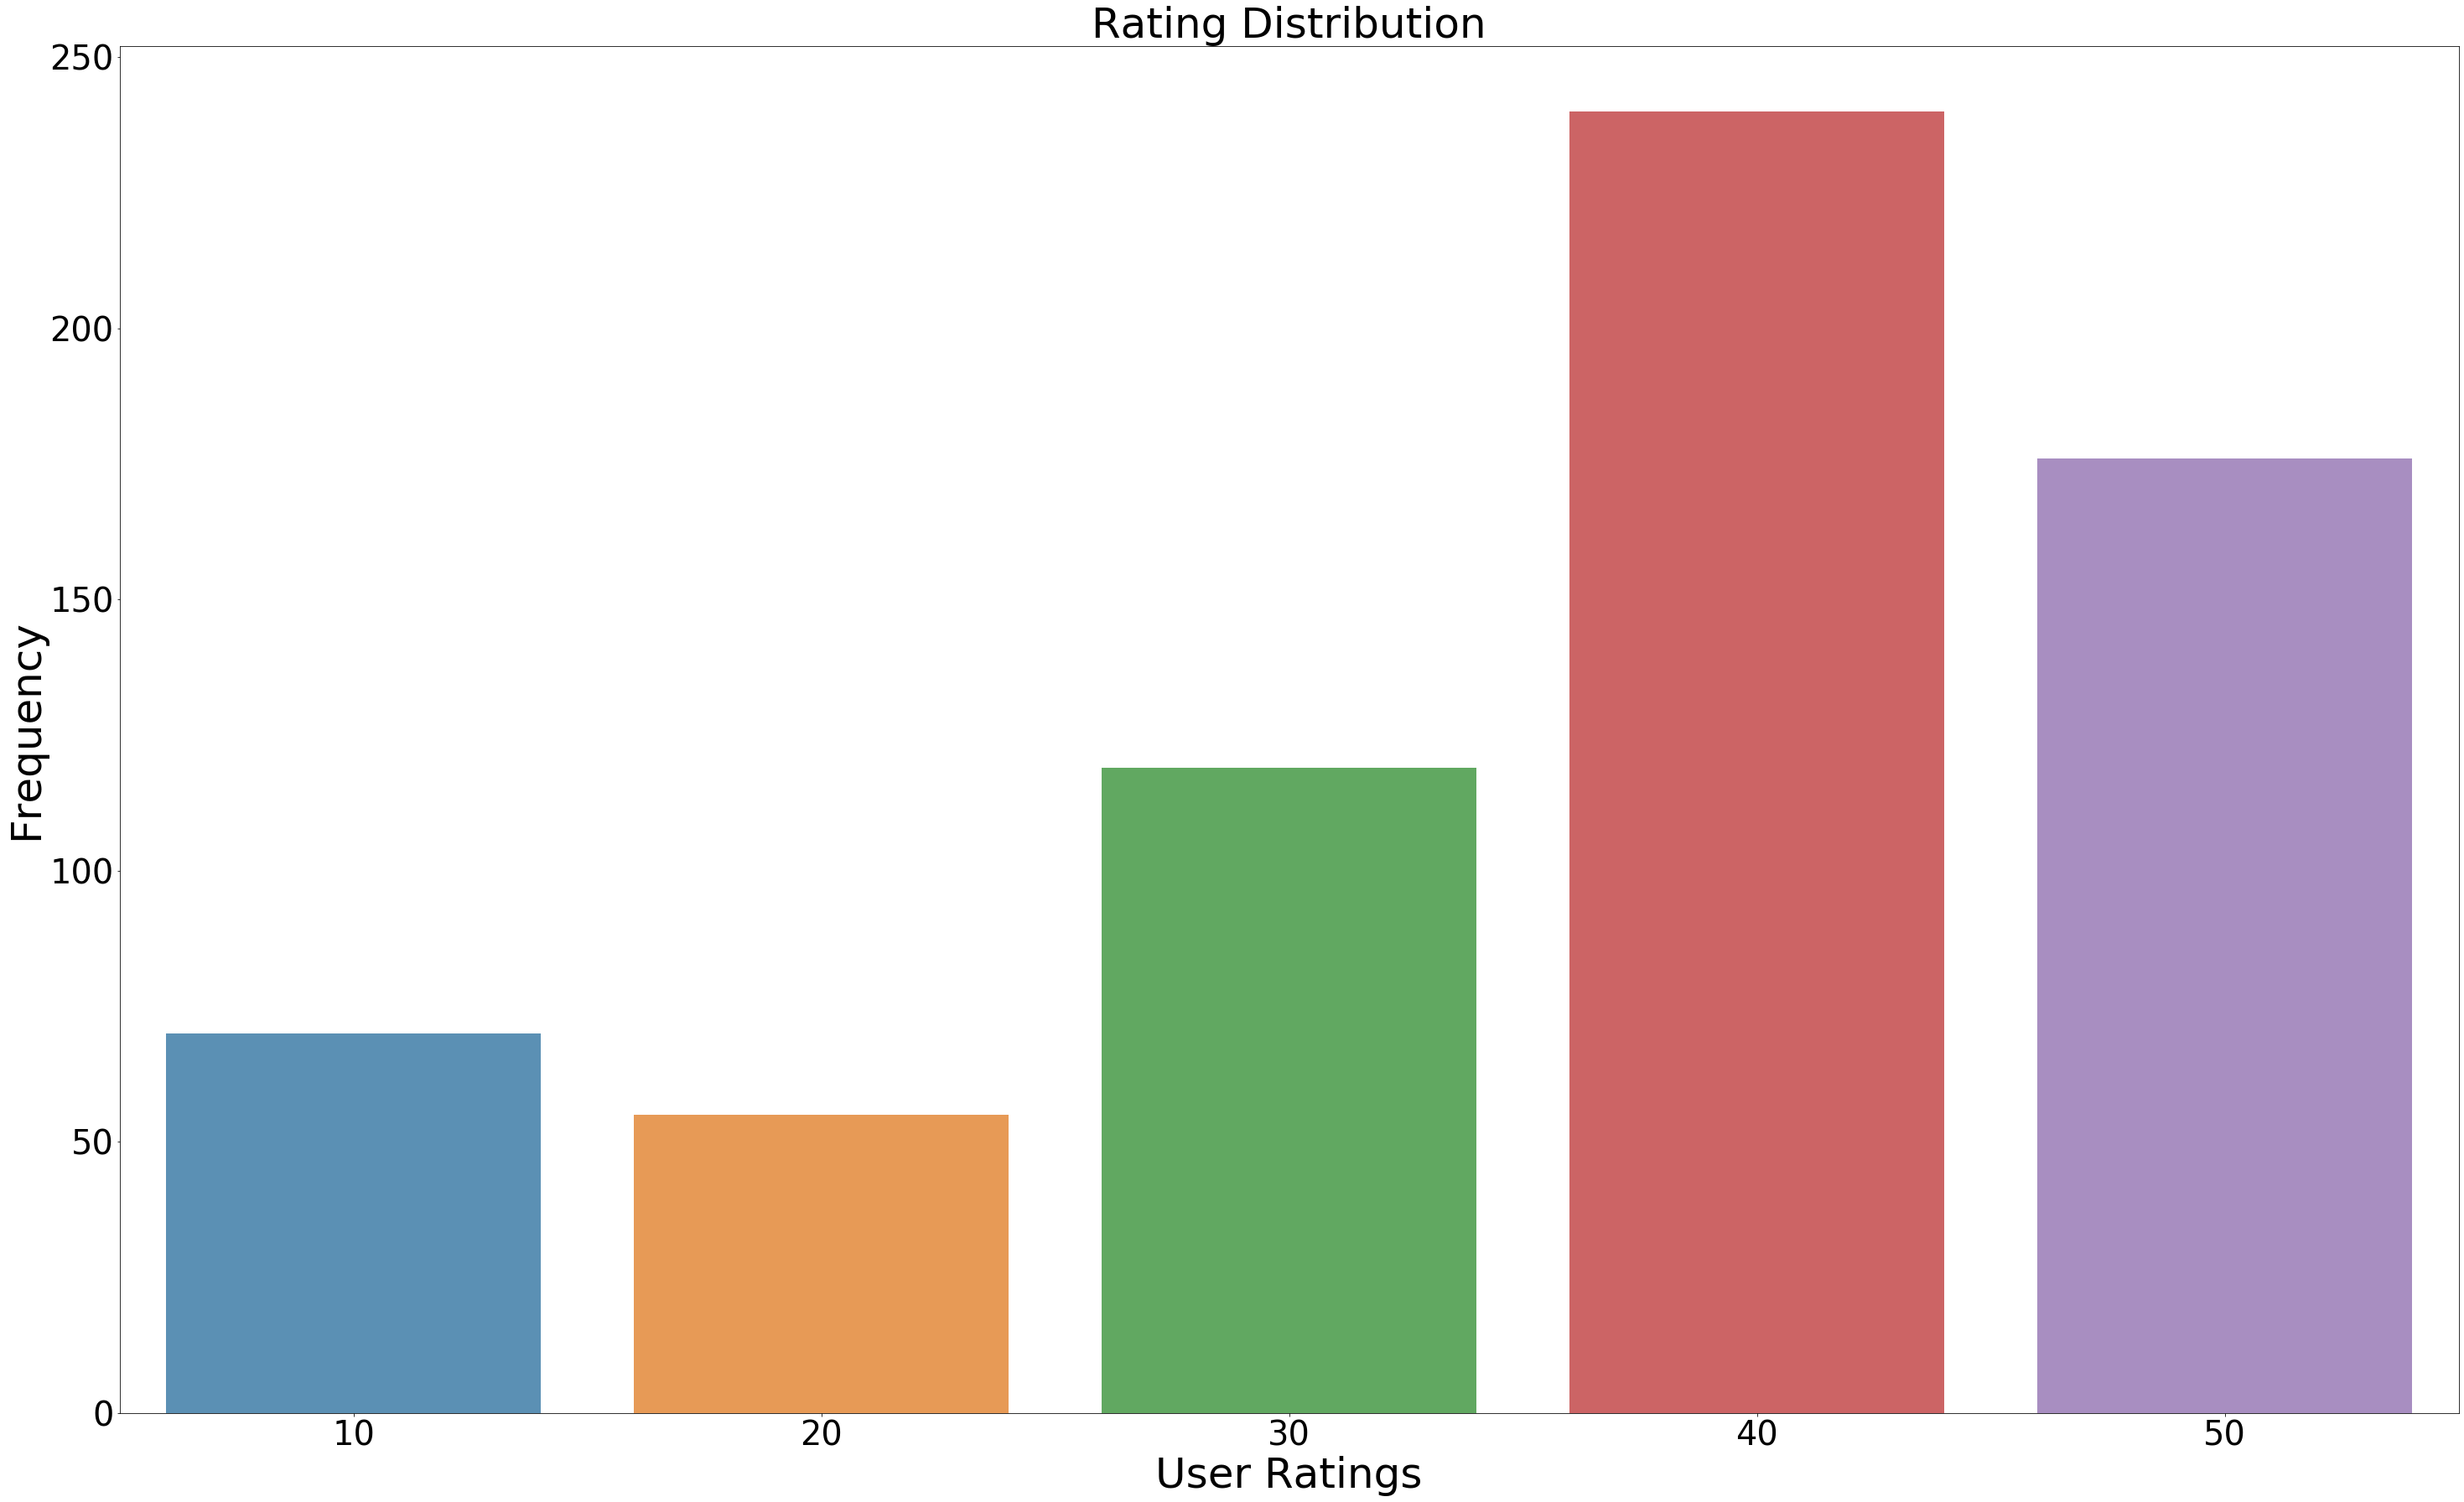

In [22]:
#rating distribution
x_rating = bb_df_new.rating.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('User Ratings', fontsize=50)
plt.xticks(fontsize=40)

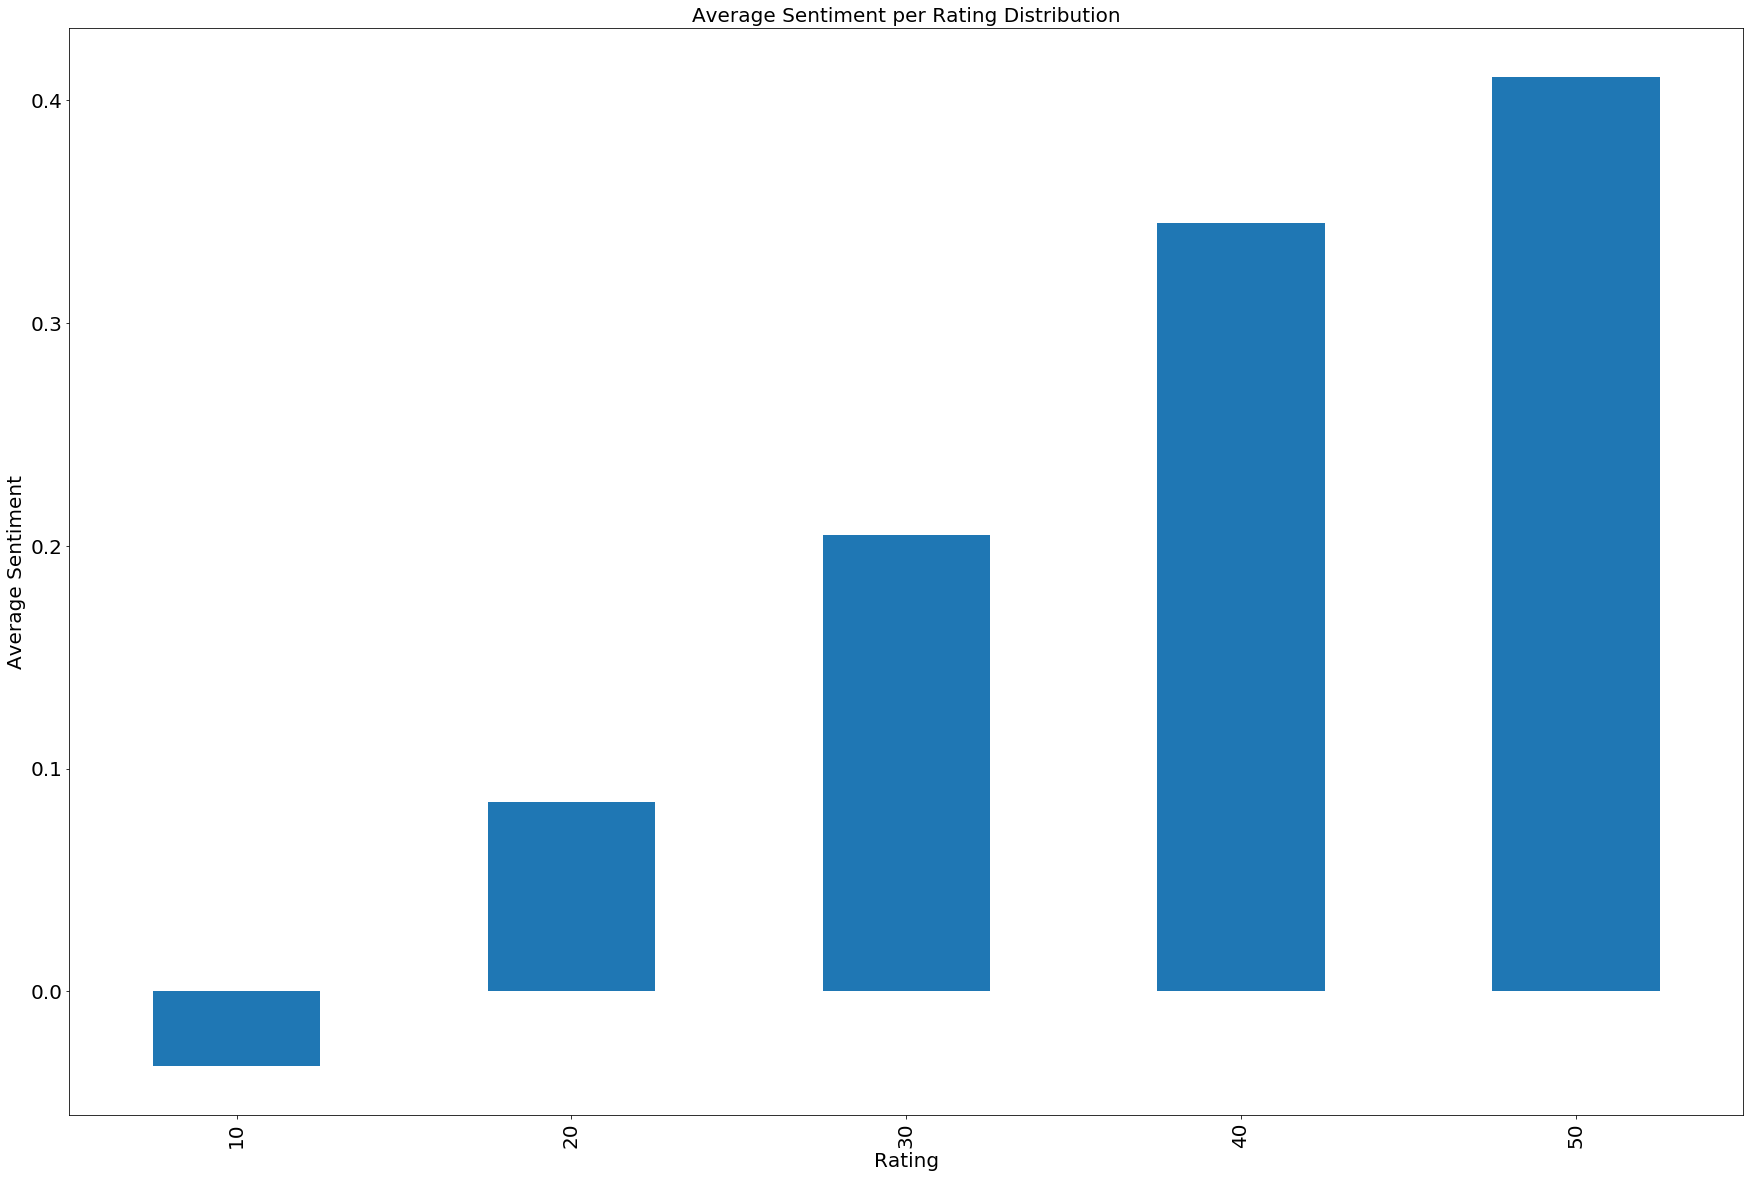

In [23]:
#sentiment and rating distribution
polarity_avg = bb_df_new.groupby('rating')['sentiment'].mean().plot(kind='bar', figsize=(30,20))
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Average Sentiment', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Average Sentiment per Rating Distribution', fontsize=20)
plt.show()

In [24]:
review_type = []
for i in bb_df_new['rating']:
    if i == 10:
        t = 'Negative'
    elif i == 20:
        t = 'Negative'
    elif i == 30:
        t = 'Negative'
    else:
        t = 'Positive'
    
    review_type.append(t)

In [25]:
bb_df_new['review_type'] = review_type
bb_df_new

C:\Users\vinay\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,rating,lemmatized,lemma_str,sentiment,review_type
0,30,"[property, good, doubt, food, upto, mark, hous...",property good doubt food upto mark housekeepin...,0.528333,Negative
1,40,"[love, everything, especially, pool, must, vis...",love everything especially pool must visit nic...,0.380000,Positive
2,50,"[nice, place, visit, family, din, staff, pleas...",nice place visit family din staff pleasant foo...,0.746667,Positive
3,50,"[event, manager, nice, place, organize, corpor...",event manager nice place organize corporate ev...,0.466667,Positive
4,50,"[amaze, weekend, stay, experience, exceptional...",amaze weekend stay experience exceptional seem...,0.411111,Positive
...,...,...,...,...,...
655,30,"[check, 3, day, whilst, exhibit, nearby, banga...",check 3 day whilst exhibit nearby bangalore ex...,0.213305,Negative
656,50,"[visit, bangalore, third, time, hotel, like, p...",visit bangalore third time hotel like paradise...,0.412755,Positive
657,30,"[hotel, 5, star, far, well, hotel, stay, india...",hotel 5 star far well hotel stay india rate 3-...,0.326323,Negative
658,10,"[hello, farook, one, favourite, hobby, holiday...",hello farook one favourite hobby holiday ever ...,0.100694,Negative


In [26]:
bb_negative = bb_df_new[bb_df_new['review_type']=='Negative']
bb_positive = bb_df_new[bb_df_new['review_type']=='Positive']
bb_positive

,rating,lemmatized,lemma_str,sentiment,review_type
1,40,"[love, everything, especially, pool, must, vis...",love everything especially pool must visit nic...,0.380000,Positive
2,50,"[nice, place, visit, family, din, staff, pleas...",nice place visit family din staff pleasant foo...,0.746667,Positive
3,50,"[event, manager, nice, place, organize, corpor...",event manager nice place organize corporate ev...,0.466667,Positive
4,50,"[amaze, weekend, stay, experience, exceptional...",amaze weekend stay experience exceptional seem...,0.411111,Positive
5,40,"[go, golden, palm, team, offsite, 35, people, ...",go golden palm team offsite 35 people overall ...,0.121190,Positive
...,...,...,...,...,...
650,40,"[one, best, resort, hotel, outskirt, bangalore...",one best resort hotel outskirt bangalore sceni...,0.555556,Positive
651,50,"[drive, airport, hotel, long, reception, hotel...",drive airport hotel long reception hotel warm ...,0.295952,Positive
652,50,"[sanjay, khan, 's, resort, excellent, room, fa...",sanjay khan 's resort excellent room fanatstic...,0.820000,Positive
654,40,"[fabulous, trip, colleague, grill, session, bu...",fabulous trip colleague grill session buiness ...,0.412500,Positive


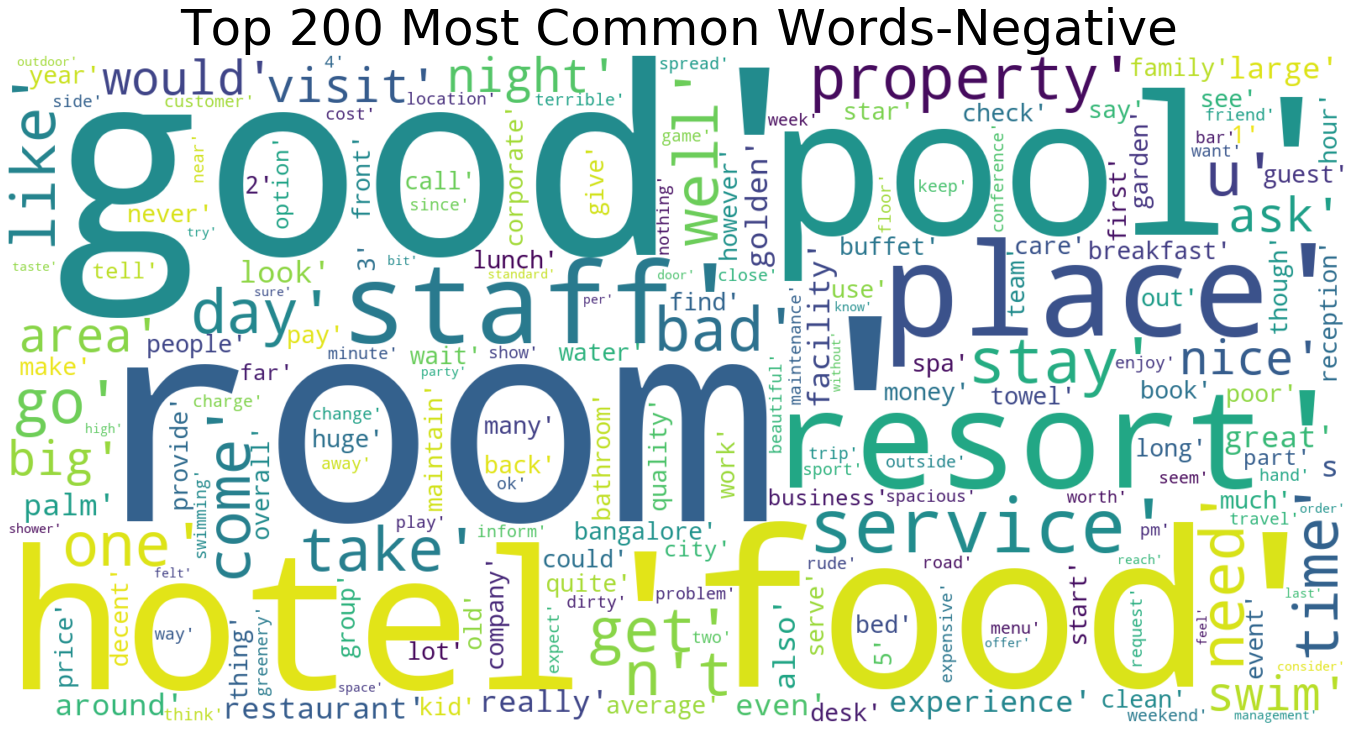

In [27]:
#word cloud for negative words

neg_words = bb_negative['lemmatized']
allwords_neg = []
for wordlist in neg_words:
    allwords_neg += wordlist
mostcommon_neg = FreqDist(allwords_neg).most_common(200)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon_neg))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 200 Most Common Words-Negative', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

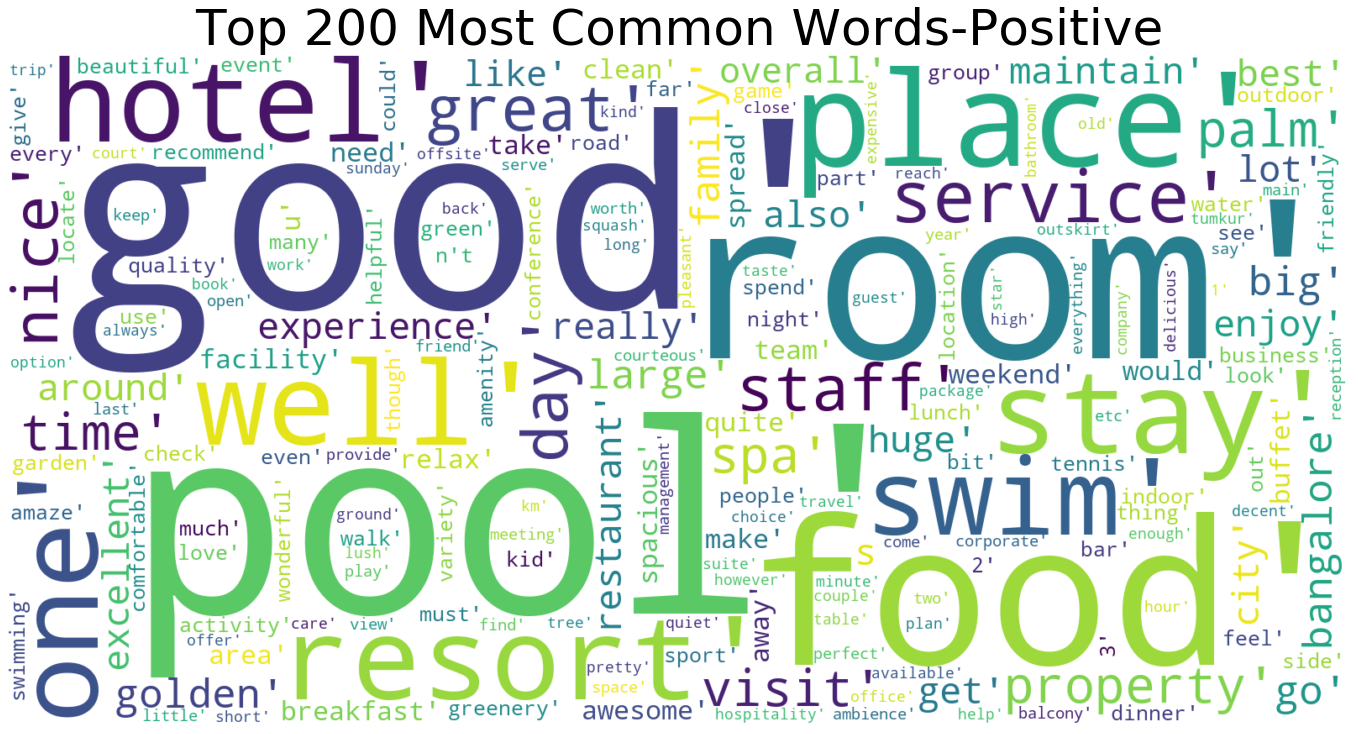

In [28]:
#word cloud for positive reviews

pos_words = bb_positive['lemmatized']
allwords_pos = []
for wordlist in pos_words:
    allwords_pos += wordlist
mostcommon_pos = FreqDist(allwords_pos).most_common(200)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon_pos))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 200 Most Common Words-Positive', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

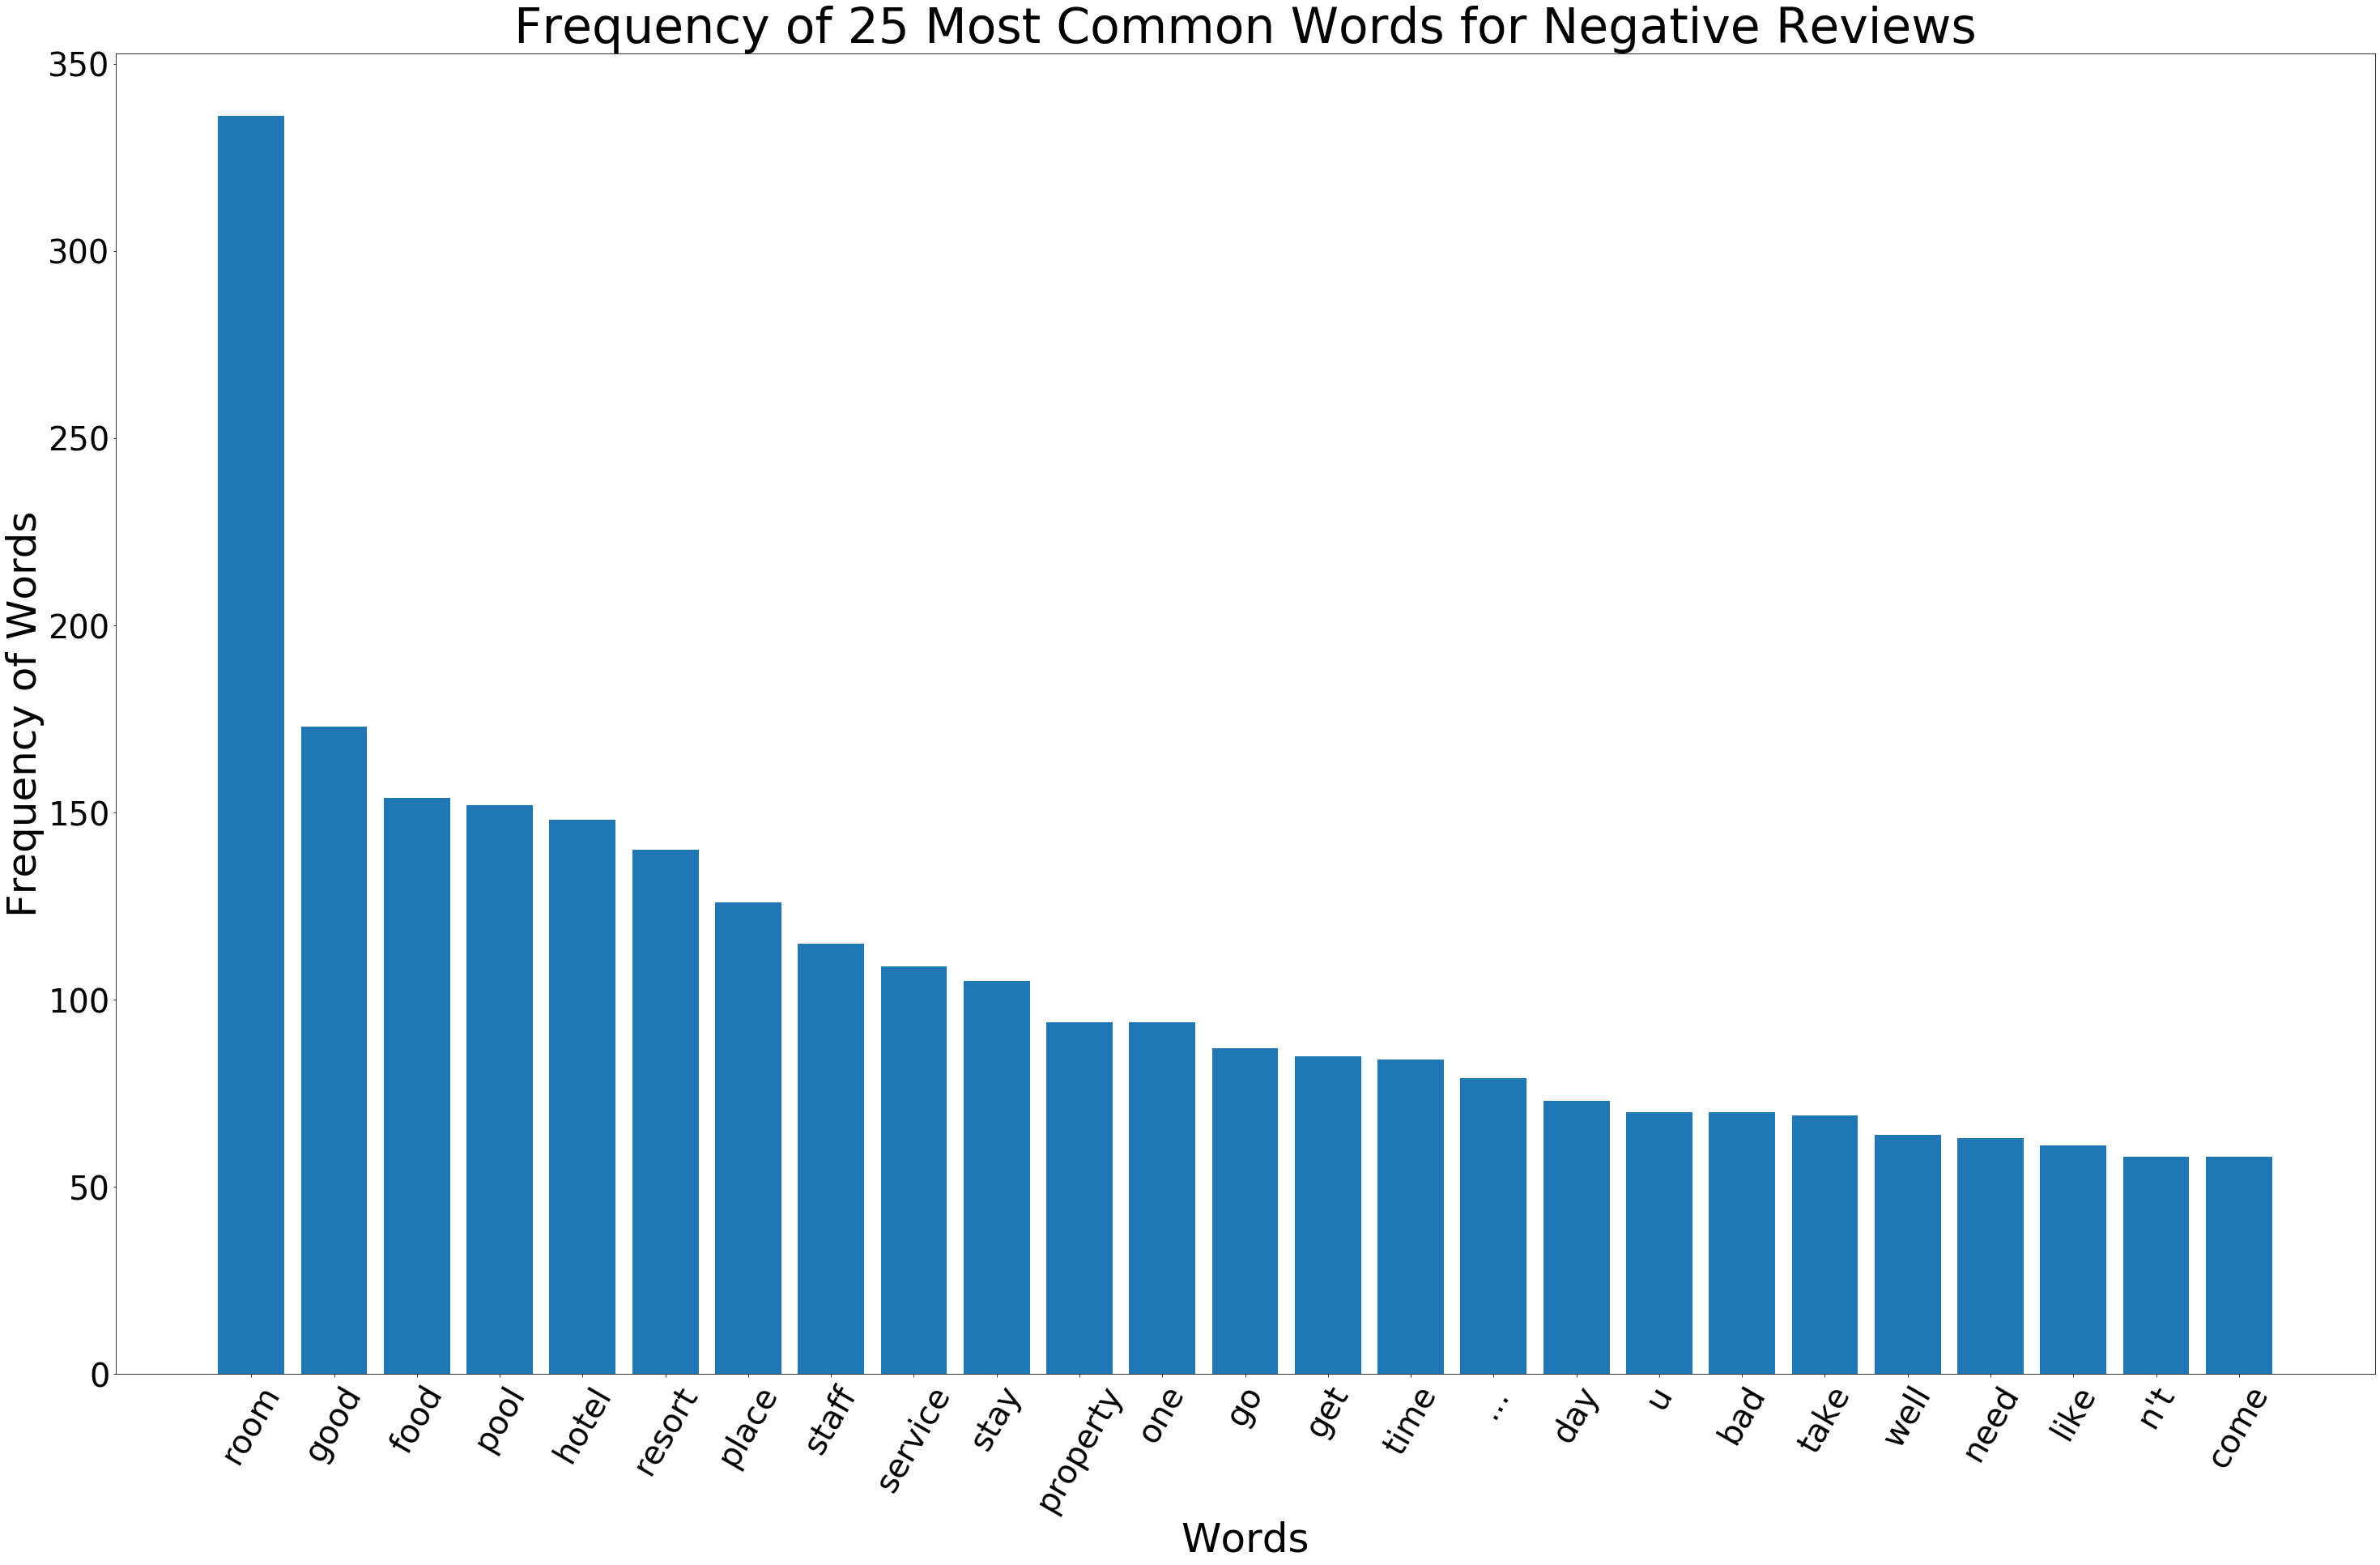

In [29]:
group_by = bb_df_new.groupby('review_type')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_neg = group_by.iloc[0]
words_neg = list(zip(*group_by_neg))[0]
freq_neg = list(zip(*group_by_neg))[1]
plt.figure(figsize=(50,30))
plt.bar(words_neg, freq_neg)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Negative Reviews', fontsize=60)
plt.show()

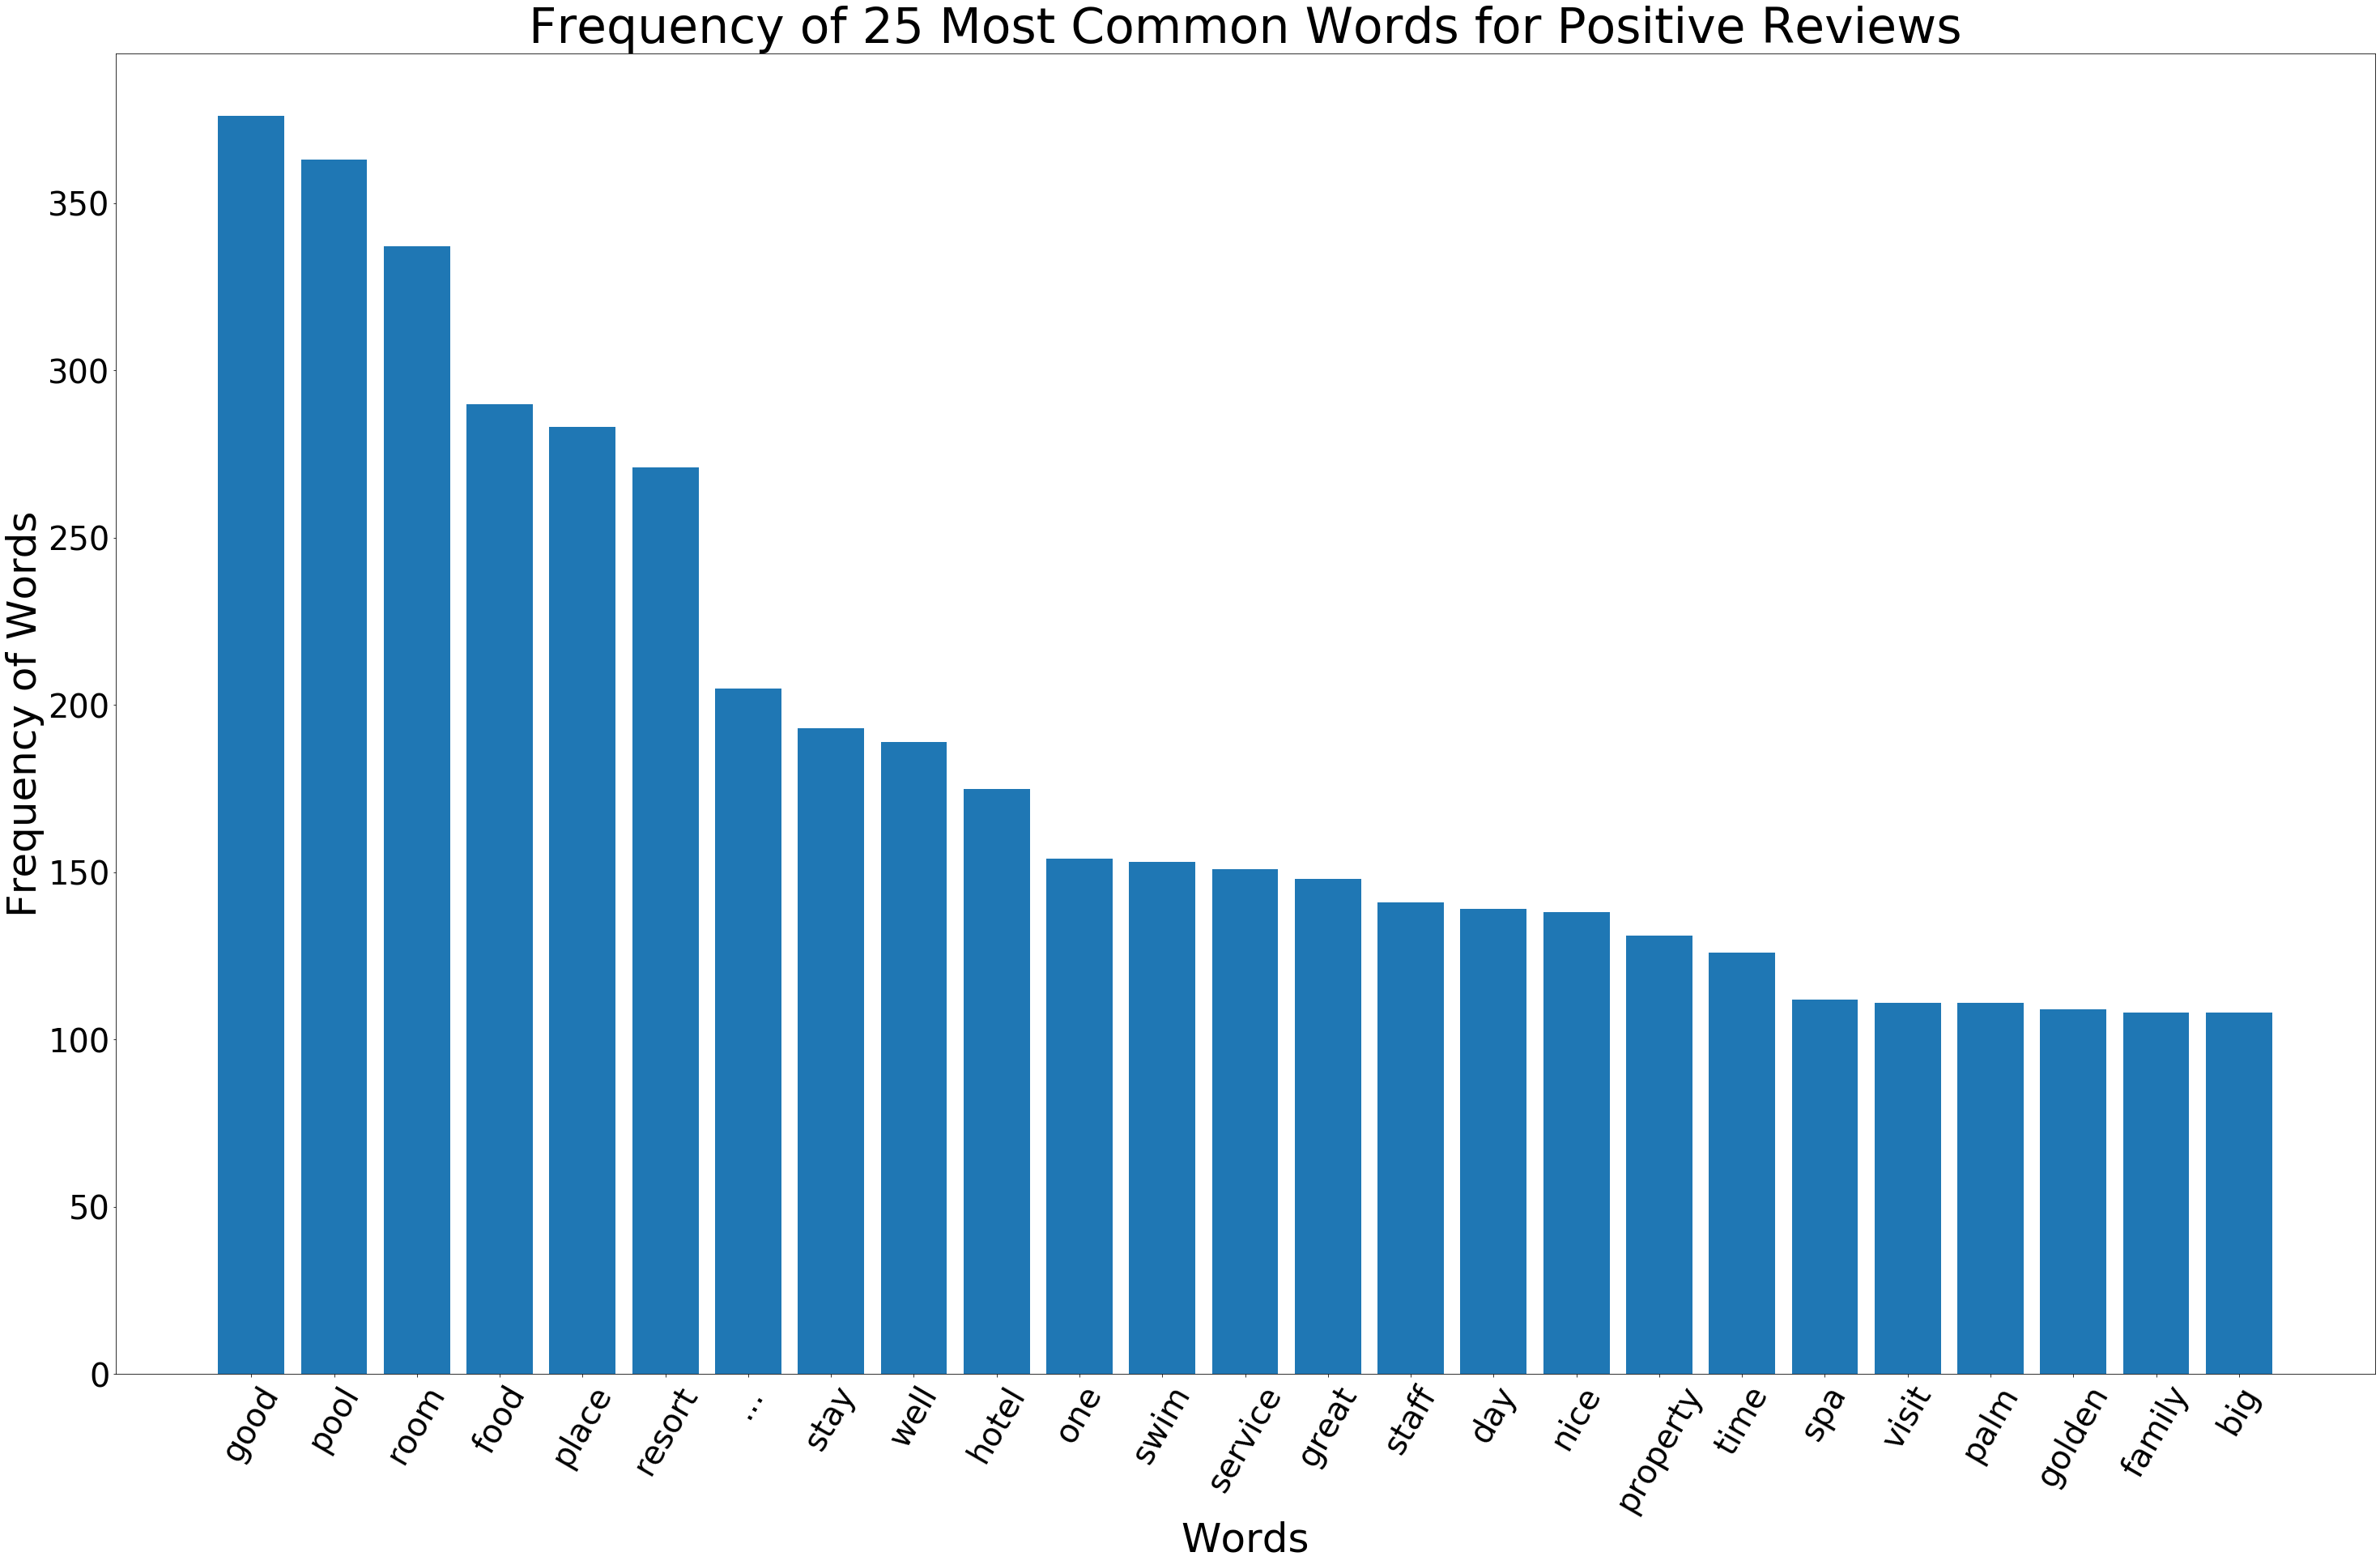

In [30]:
group_by_pos = group_by.iloc[1]
words_pos = list(zip(*group_by_pos))[0]
freq_pos = list(zip(*group_by_pos))[1]
plt.figure(figsize=(50,30))
plt.bar(words_pos, freq_pos)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Positive Reviews', fontsize=60)
plt.show()

****TOPIC MODELLING****

***FOR POSITIVE REVIEWS***

In [49]:
from gensim import corpora
dictionary_neg = corpora.Dictionary(bb_negative['lemmatized'])
corpus = [dictionary_neg.doc2bow(text) for text in bb_negative['lemmatized']]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary_neg.save('dictionary_neg.gensim')
ldamodel_neg = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary_neg, passes=20)
ldamodel_neg.save('neg_model.gensim')
topics = ldamodel_neg.print_topics(num_words=8)
for topic in topics:
    print(topic)

(0, '0.013*"food" + 0.012*"day" + 0.012*"hotel" + 0.010*"..." + 0.009*"room" + 0.008*"place" + 0.008*"out" + 0.008*"quite"')
(1, '0.023*"place" + 0.018*"resort" + 0.008*"food" + 0.008*"room" + 0.007*"come" + 0.007*"’" + 0.006*"golden" + 0.006*"palm"')
(2, '0.024*"room" + 0.014*"food" + 0.012*"pool" + 0.010*".." + 0.009*"good" + 0.009*"need" + 0.009*"resort" + 0.009*"come"')
(3, '0.025*"good" + 0.015*"pool" + 0.013*"place" + 0.013*"resort" + 0.013*"room" + 0.012*"food" + 0.010*"staff" + 0.009*"get"')
(4, '0.026*"room" + 0.012*"..." + 0.012*"hotel" + 0.010*"stay" + 0.009*"good" + 0.009*"food" + 0.008*"resort" + 0.008*"staff"')
(5, '0.018*"room" + 0.014*"service" + 0.013*"good" + 0.013*"pool" + 0.011*"stay" + 0.011*"resort" + 0.010*"food" + 0.010*"hotel"')
(6, '0.011*"hotel" + 0.010*"get" + 0.007*"food" + 0.007*"room" + 0.007*"..." + 0.007*"go" + 0.006*"golden" + 0.006*"palm"')
(7, '0.009*"pool" + 0.008*"service" + 0.007*"rate" + 0.007*"feedback" + 0.006*"consider" + 0.006*"trip" + 0.006*

In [ ]:
dictionary_neg = gensim.corpora.Dictionary.load('dictionary_neg.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
ldaneg = gensim.models.ldamodel.LdaModel.load('neg_model.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldaneg, corpus, dictionary_neg, sort_topics=False)
pyLDAvis.display(lda_display)

***FOR POSITIVE REVIEWS***

In [48]:
from gensim import corpora
dictionary_pos = corpora.Dictionary(bb_positive['lemmatized'])
corpus_pos = [dictionary_pos.doc2bow(text) for text in bb_positive['lemmatized']]
import pickle
pickle.dump(corpus_pos, open('corpus_pos.pkl', 'wb'))
dictionary_pos.save('dictionary_pos.gensim')
ldamodel_pos = gensim.models.ldamodel.LdaModel(corpus_pos, num_topics=10, id2word = dictionary_pos, passes=20)
ldamodel_pos.save('pos_model.gensim')
topics_pos = ldamodel_pos.print_topics(num_words=8)
for topic in topics_pos:
    print(topic)

(0, '0.034*"good" + 0.020*"room" + 0.019*"food" + 0.017*"pool" + 0.016*"place" + 0.014*"stay" + 0.013*"staff" + 0.011*"resort"')
(1, '0.016*"pool" + 0.015*"one" + 0.014*"resort" + 0.013*"room" + 0.012*"hotel" + 0.011*"good" + 0.011*"place" + 0.010*"stay"')
(2, '0.014*"room" + 0.013*"hotel" + 0.012*"good" + 0.010*"..." + 0.010*"place" + 0.010*"stay" + 0.010*"amaze" + 0.009*"service"')
(3, '0.020*"resort" + 0.016*"great" + 0.016*"food" + 0.016*"place" + 0.015*"pool" + 0.014*"well" + 0.014*"good" + 0.013*"visit"')
(4, '0.009*"resort" + 0.008*"package" + 0.008*"complete" + 0.006*"even" + 0.005*"room" + 0.005*"reception" + 0.005*"go" + 0.005*"experience"')
(5, '0.018*"well" + 0.016*"pool" + 0.012*"food" + 0.012*"room" + 0.008*"large" + 0.008*"maintain" + 0.008*"good" + 0.007*"staff"')
(6, '0.023*"pool" + 0.022*"room" + 0.021*"good" + 0.019*"place" + 0.016*"resort" + 0.014*"food" + 0.013*"service" + 0.011*"nice"')
(7, '0.020*"good" + 0.017*"room" + 0.012*"stay" + 0.010*"resort" + 0.009*"spa"

In [ ]:
dictionary_pos = gensim.corpora.Dictionary.load('dictionary_pos.gensim')
corpus_pos = pickle.load(open('corpus_pos.pkl', 'rb'))
ldapos = gensim.models.ldamodel.LdaModel.load('pos_model.gensim')
import pyLDAvis.gensim
lda_display_pos = pyLDAvis.gensim.prepare(ldapos, corpus, dictionary_pos, sort_topics=False)
pyLDAvis.display(lda_display_pos)